In [1]:
import os
import random

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import tensorflow as tf
from tqdm import tqdm

from nowcasting.unet_conv3d import unet_conv3d
from nowcasting.unet import res2
from nowcasting.utils import (CustomGenerator, model_analysis,
                              recreate_directory)


def get_predictions_by_run(model_type, experiment_name, run_name):
    # Create path to saved weights
    # Get dataframe of mlflow runs by experiment name
    experiment_id = mlflow.get_experiment_by_name(
        experiment_name).experiment_id
    df = mlflow.search_runs(experiment_id)
    # Get run by name
    run = df[df["tags.mlflow.runName"] == run_name].iloc[0]

    run_id = run["run_id"]
    experiment_id = run["experiment_id"]
    weights_path = f"{mlruns_path}/{experiment_id}/{run_id}/artifacts/script_n1.h5"

    # Get number of base filters used so that model has the correct number of parameters
    num_filters_base = int(run["params.hpo_num_filters_base"])

    # Create model and load weights
    if model_type != "unet":
        model = res2((12, 256, 620, 4),
                     num_filters_base=num_filters_base,
                     dropout_rate=0)
    else:
        model = unet_conv3d((12, 256, 620, 4),
                            num_filters_base=num_filters_base,
                            dropout_rate=0)

    model.load_weights(weights_path)
    model.compile(loss="mean_square_error", metrics=["mae", "mse"])

    y_pred = model.predict(eval_dataset)
    y_pred[y_pred < 0] = 0
    return y_pred


seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

CB_color_cycle = [
    '#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3',
    '#999999', '#e41a1c', '#dede00'
]

# Absolute paths
mlruns_path = "/panfs/jay/groups/6/csci8523/joren015/repos/Nowcasting/mlruns"
dataset_directory = "/panfs/jay/groups/6/csci8523/joren015/repos/Nowcasting/data/datasets/12_8_0_20_1.0"

# Relative paths
mlruns_path = "mlruns"
dataset_directory = "data/datasets/12_8_0_20_1.0"

# Set mlflow tracking uri so we can find the run results
mlflow.set_tracking_uri(mlruns_path)

split = "test"

split_directory = f"{dataset_directory}/{split}"
gfs_split_directory = f"{dataset_directory}/gfs/{split}"
eval_paths = [f"{split_directory}/{x}" for x in os.listdir(split_directory)]
gfs_paths = [
    f"{gfs_split_directory}/{x}" for x in os.listdir(gfs_split_directory)
]
eval_dataset = CustomGenerator(eval_paths, 1, shuffle=False)
gfs_dataset = CustomGenerator(gfs_paths, 1, shuffle=False)

# Get run with lowest validation mse
# run = df.sort_values(by="metrics.val_mse").iloc[0]

# Create path to saved weights
# Get dataframe of mlflow runs by experiment name
y_pred_mse = get_predictions_by_run("res2", "hpo_res_mse_12_8_0_20_1.0",
                                    "receptive-sheep-254")
y_pred_kgl = get_predictions_by_run("res2", "hpo_res_kgl_12_8_0_20_1.0",
                                    "fearless-finch-667")
y_pred_unet = get_predictions_by_run("unet", "hpo_unet_conv3d_12_8_0_20_1.0",
                                     "gregarious-ape-882")

# Getting inputs, outputs, and predictions (including gfs and persist) for all samples

Xs = []
ys = []
gfss = []
y_persists = []
for k in tqdm(range(y_pred_mse.shape[0])):
    X, y = eval_dataset.__getitem__(k)
    _, gfs = gfs_dataset.__getitem__(k)
    X = X[0]
    y = y[0][:, :, :, 0]
    gfs = gfs[0][:, :, :, 0]
    y_persist = np.array([X[-1, :, :, 0] for i in range(8)])

    Xs.append(X)
    ys.append(y)
    gfss.append(gfs)
    y_persists.append(y_persist)

X = np.array(Xs)
y = np.array(ys)
y_gfs = np.array(gfss)
y_persist = np.array(y_persists)

# Finding representative examples to plot
y[y < 0] = 0
y_gfs[y_gfs < 0] = 0

2022-12-21 20:49:09.806276: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 20:49:10.012395: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-21 20:49:10.780154: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-21 20:49:10.780231: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or direc

37/37 [==============================] - 15s 244ms/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 12, 256, 62  0           []                               
                                0, 4)]                                                            
                                                                                                  
 batch_normalization_14 (BatchN  (None, 12, 256, 620  16         ['input_3[0][0]']                
 ormalization)                  , 4)                                                              
                                                                                                  
 zero_padding3d_2 (ZeroPadding3  (None, 12, 256, 624  0          ['batch_normalization_14[0][0]'] 
 D)                             , 4)

2022-12-21 20:49:54.696878: I tensorflow/core/grappler/optimizers/generic_layout_optimizer.cc:370] Cancel Transpose nodes around Pad: transpose_before=model_2/batch_normalization_14/FusedBatchNormV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer pad=model_2/zero_padding3d_2/Pad transpose_after=model_2/conv3d_8/Conv3D-0-TransposeNDHWCToNCDHW-LayoutOptimizer


37/37 [==============================] - 2s 36ms/step


100%|██████████| 37/37 [00:01<00:00, 19.30it/s]


In [2]:
print(y.shape)
print(y_pred_mse.shape)
print(y_pred_kgl.shape)
print(y_pred_unet.shape)
print(y_gfs.shape)


(37, 8, 256, 620)
(37, 8, 256, 620)
(37, 8, 256, 620)
(37, 8, 256, 620)
(37, 8, 256, 620)


In [3]:
i = 13
j = [1,3,5,7]
y_plot = y[i][j]
y_pred_mse_plot = y_pred_mse[i][j]
y_pred_kgl_plot = y_pred_kgl[i][j]
y_pred_unet_plot = y_pred_unet[i][j]
y_gfs_plot = y_gfs[i][j]

In [4]:
print(y_plot.shape)
print(y_pred_mse_plot.shape)
print(y_pred_kgl_plot.shape)
print(y_pred_unet_plot.shape)
print(y_gfs_plot.shape)


(4, 256, 620)
(4, 256, 620)
(4, 256, 620)
(4, 256, 620)
(4, 256, 620)


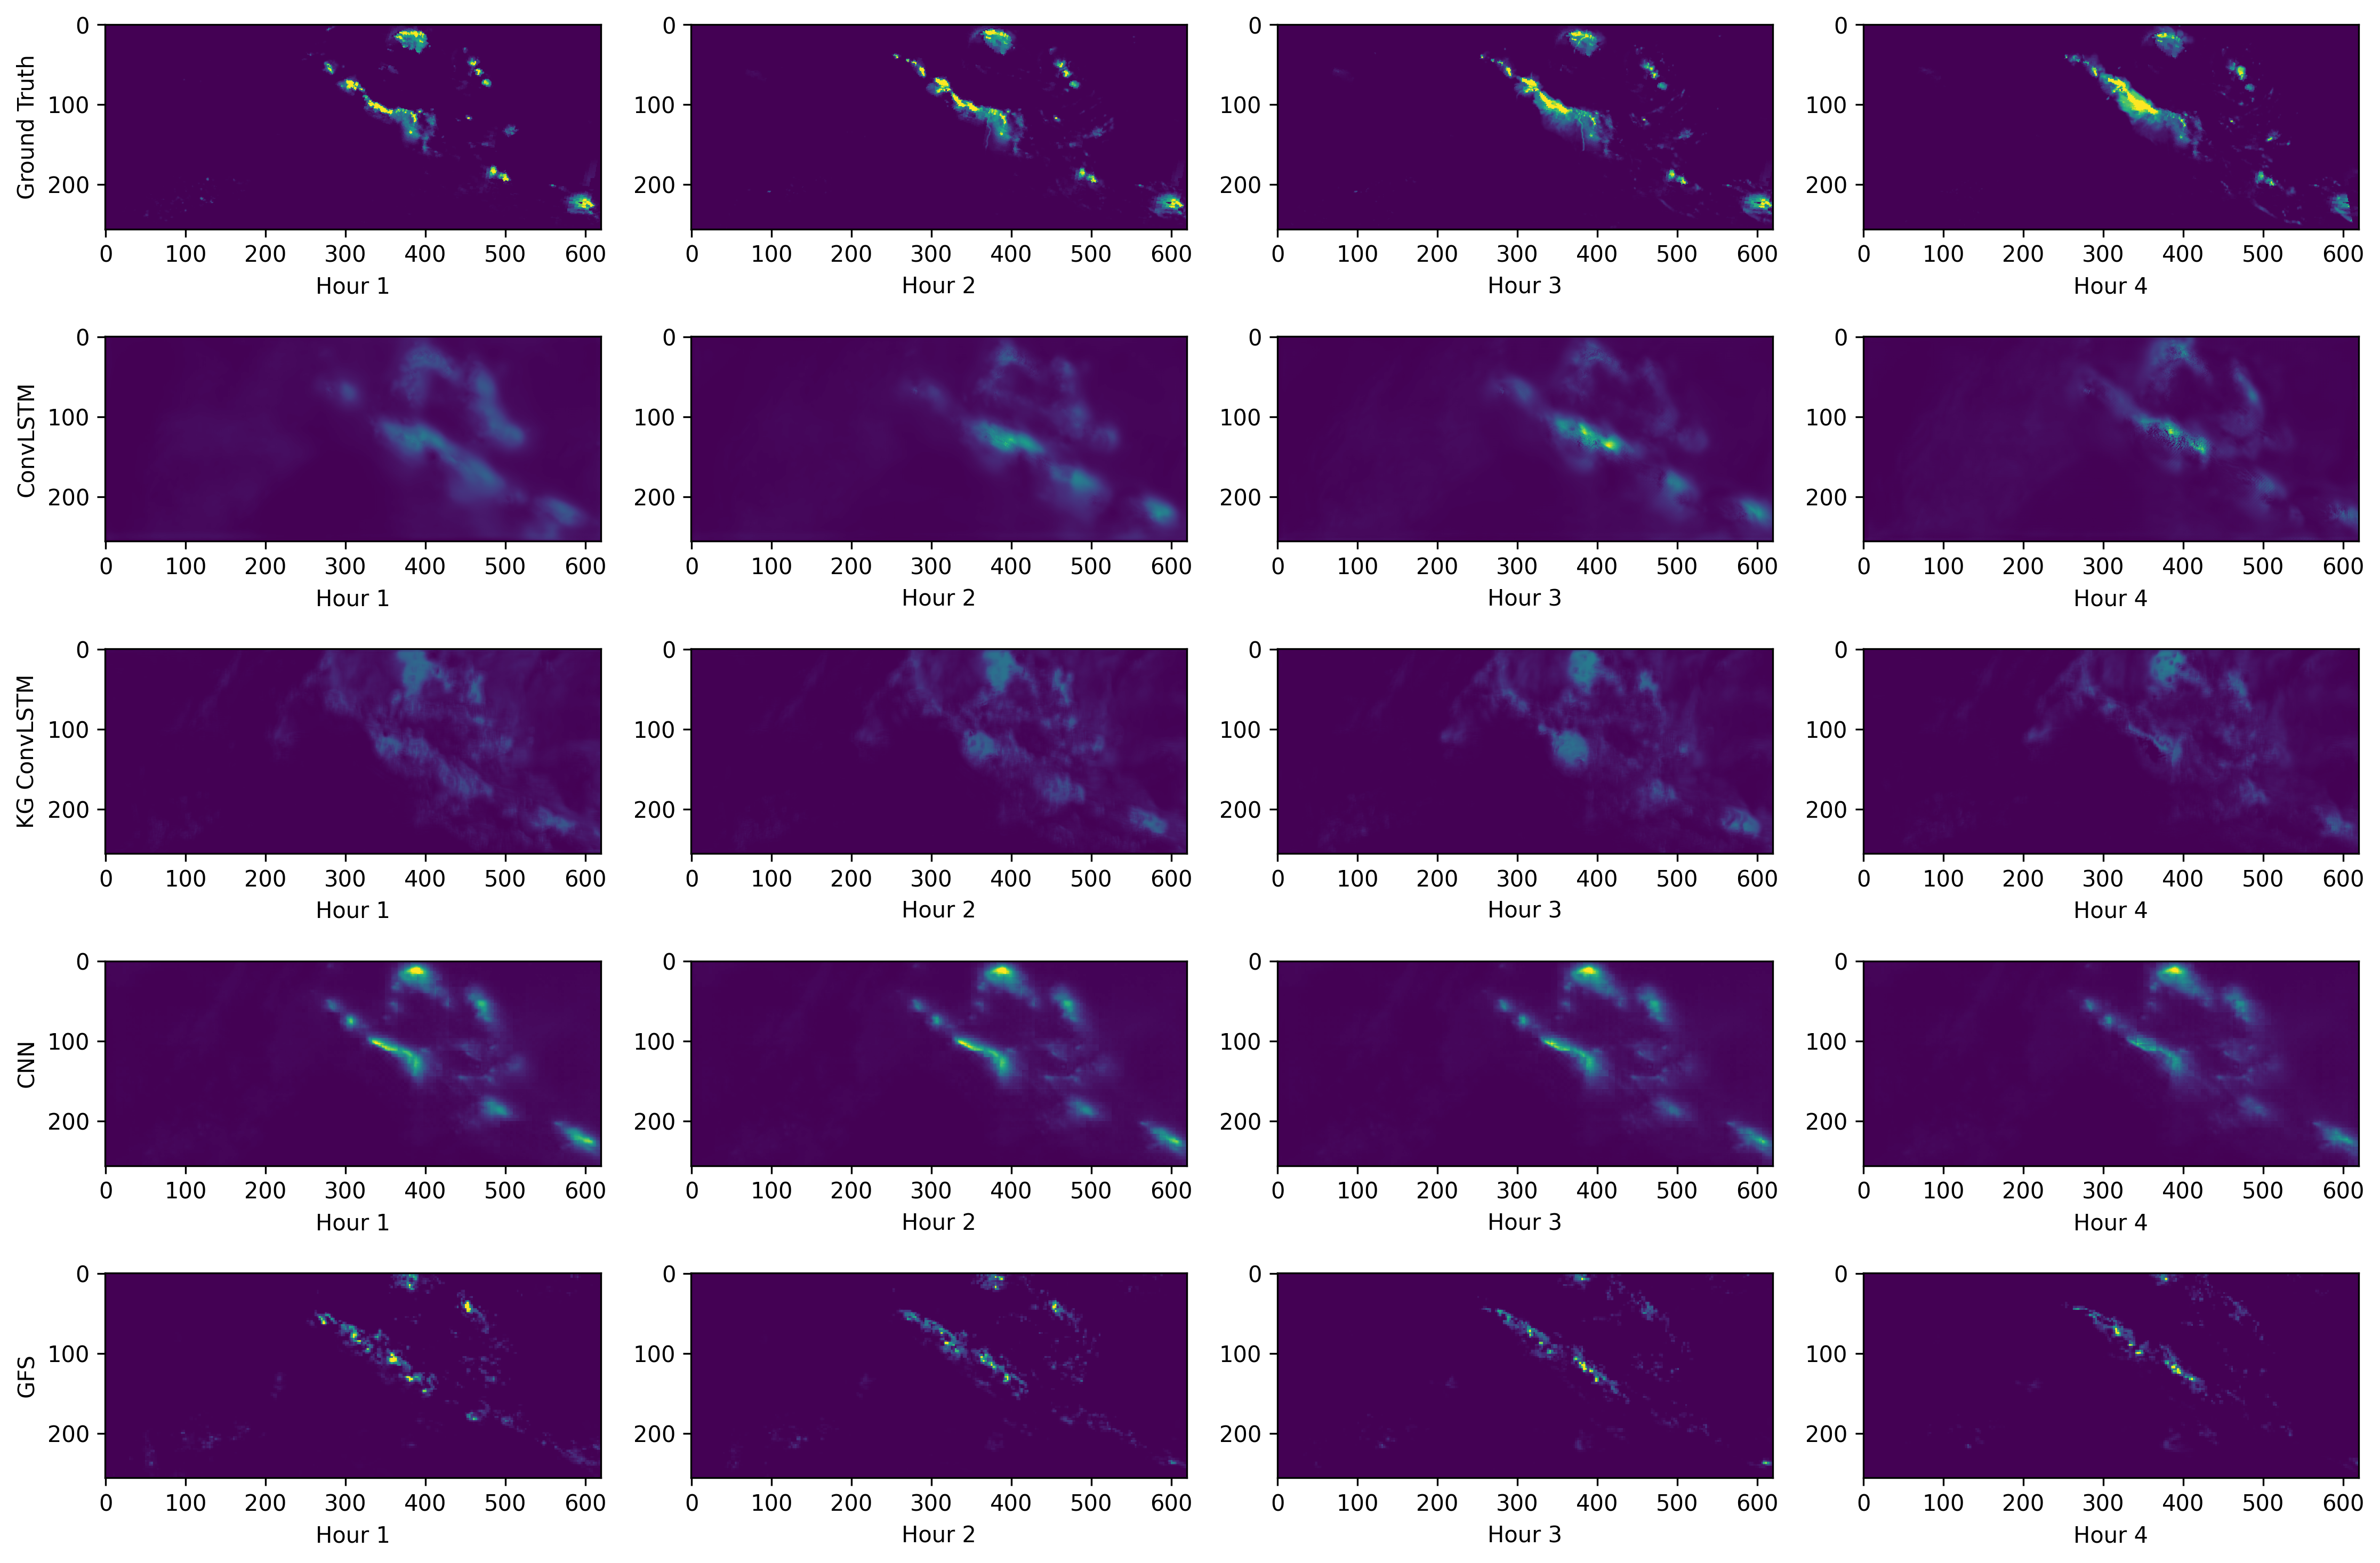

In [5]:
vmin = 0
vmax = 20

fig, axs = plt.subplots(5, 4, figsize=(15, 10))
file_name = "example.png"

for i in range(y_plot.shape[0]):
    axs[0, i].imshow(y_plot[i], vmin=vmin, vmax=vmax)
    axs[0, i].set_xlabel(f"Hour {i+1}")
    axs[1, i].imshow(y_pred_mse_plot[i], vmin=vmin, vmax=vmax)
    axs[1, i].set_xlabel(f"Hour {i+1}")
    axs[2, i].imshow(y_pred_kgl_plot[i], vmin=vmin, vmax=vmax)
    axs[2, i].set_xlabel(f"Hour {i+1}")
    axs[3, i].imshow(y_pred_unet_plot[i], vmin=vmin, vmax=vmax)
    axs[3, i].set_xlabel(f"Hour {i+1}")
    axs[4, i].imshow(y_gfs_plot[i], vmin=vmin, vmax=vmax)
    axs[4, i].set_xlabel(f"Hour {i+1}")

axs[0, 0].set_ylabel("Ground Truth")
axs[1, 0].set_ylabel("ConvLSTM")
axs[2, 0].set_ylabel("KG ConvLSTM")
axs[3, 0].set_ylabel("CNN")
axs[4, 0].set_ylabel("GFS")

fig.tight_layout()
fig.savefig(file_name, bbox_inches="tight")